In [3]:
import numpy as np
import matplotlib.pyplot as plt

% matplotlib inline

# Equações diferenciais

Uma equação diferencial é uma equação que envolve uma função desconhecida e suas derivadas. Um exemplo é a equação para o crescimento populacional, que diz que na ausência de recursos escassos, a taxa de crescimento de uma população é proporcional à própria população. Em linguagem matemática, se y(t) for o tamanho de uma população no instante t, então y'(t) = lambda * y(t).

Nesta seção nos dedicaremos a descobrir métodos numéricos capazes de resolver (ainda que aproximadamente) este tipo de equação.

Existem alguns casos simples em que podemos "chutar" a resposta correta. Na equação do crescimento populacional, sabemos que uma função igual à propria derivada é a exponencial. Ajustando alguns fatores vemos que y(t) = A exp(lambda * t) é uma solução válida. No entanto, basta realizar pequenas modificações na equação diferencial para que ela fique extremamente difícil de se resolver:

    $y'(t) = lambda * y(t) * (C - y(t))$

No modelo acima introduzimos o conceito de "capacidade ambiental" à dinâmica populacional de modo que existe um
valor máximo de população suportada pelo ambiente (acima deste valor, o crescimento se torna negativo pois não existem recursos no ambiente para manter a população. É fácil ver que se y(t) = C, o crescimento é nulo e a população se mantêm constante.

## Método de Euler

o método mais simples de solução envolve transformar $y'(t)=f(y, t)$ em uma equação de diferenças finitas. Deste modo, 
fazemos $\frac{dy}{\tau} = \frac {y_{n+1} - y_n}{dt}. A idéia é escolher um valor de dt suficientemente pequeno
para que a derivada possa ser aproximada por uma diferença finita. A partir daí, reorganizamos os termos para 
ter

    $y_{n+1} = y_n + f(y_n, t) \tau$
    
Em código, temos:

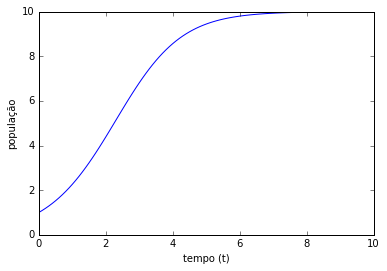

In [4]:
# Inicialização das variáveis
t = 0
tau = 0.1
lambd = 0.1
C = 10
y0 = 1.0

# Listas que guardam os tempos e valores de y
T, Y = [t], [y0]

# Definimos a função f(y, t) que caracteriza a equação diferencial
def f(y, t):
    return lambd * y * (C - y) 

# Avança 100 passos (até t=10)
y = y0
while t < 10:
    y = y + f(y, t) * tau
    t += tau
    T.append(t)
    Y.append(y)
    
# Mostramos um gráfico
plt.plot(T, Y)
plt.axis([0, 10, 0, 10])
plt.xlabel('tempo (t)')
plt.ylabel('população')

Vamos organizar este método em uma função reutilizável. Com isto será mais fácil explorar diferentes propriedades do método de Euler.

In [5]:
def euler(f, y0, tf, tau=0.1):
    """
    Resolve uma equação diferencial do tipo y'(t) = f(y, t) utilizando o método de Euler.
    
    Args:
        f: função do tipo f(y, t)
        y0: valor inicial de y em t=0
        tf: tempo final
        tau: passo temporal entre cada iteração.
    
    Results:
        Retorna dois vetores T, Y com os valores de t e y em cada passo.
    """
    
    y = y0
    t = 0
    T, Y = [t], [y]
    while t < tf:
        y = y + f(y, t) * tau
        t += tau
        T.append(t)
        Y.append(y)
    return np.array(T), np.array(Y)

O método de Euler exige que nós escolhamos o parâmetro dt que designa o passo em cada iteração. Idealmente dt deveria se aproximar de zero, mas isto faz com que o número de iterações necessárias para resolver a equação em um determinado intervalo exploda. Existe um *tradeoff*: aumente dt para aumentar a eficiência computacional, mas pague com uma pior precisão numérica.

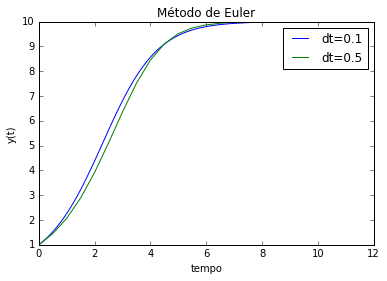

In [6]:
T1, Y1 = euler(f, y0=1, tf=10, tau=0.1)
T2, Y2 = euler(f, y0=1, tf=10, tau=0.5)
plt.plot(T1, Y1, label='dt=0.1')
plt.plot(T2, Y2, label='dt=0.5')
plt.legend(loc='best')
plt.title('Método de Euler')
plt.xlabel('tempo')
plt.ylabel('y(t)')


Quando avaliamos o tempo de execução o *tradeoff* fica claro

In [7]:
%timeit -n1000 euler(f, y0=1, tf=10, tau=0.1)
%timeit -n1000 euler(f, y0=1, tf=10, tau=1.0)

1000 loops, best of 3: 108 µs per loop
1000 loops, best of 3: 13.5 µs per loop


## Métodos de Runge-Kutta

Podemos sempre melhorar a qualidade da solução utilizando o método de Euler fazendo dt diminuir. Esta abordagem,
no entanto, não é muito eficaz computacionalmente. Existem alguns métodos um pouco mais complicados que o método de Euler, mas que apresentam uma performance *muito* melhor. Quase sempre este aumento de complexidade é compensado pela qualidade da solução.

A classe mais importante e flexível de métodos para resoluções de EDOs é, sem dúvida nenhuma, a dos métodos Runge-Kutta. O próprio método de Euler pode ser compreendido como um método Runge-Kutta de baixa ordem.

Todo método de Runge-Kutta começa com um *tableu*. Considere o *tableau* do método de Heun:

```
  0 |
2/3 | 2/3	
----+--------
    | 1/4  3/4
```

O Runge-Kutta é uma regra hierárquica baseada em várias aproximações da derivada de y(t) dentro do intervalo
[t, t + dt]. Cada uma destas aproximações é conhecida como um coeficiente **k**. A primeira linha do *tableau* mostra como se calcula o coeficiente k1. No caso $k_1 = f(y, t)$. O valor do lado esquerdo da barra vertical especifica o acrescimo ao argumento temporal, que neste caso é nulo. Já o valor do lado direito representa um acréscimo ao valor de y com base nos k's anteriores. Para k1 este valor sempre será vazio.

No segundo coeficiente temos $k_2 = f\left(y + \frac23 k_1 \tau, t + \frac23 \tau\right)$.

Finalmente, a última linha representa os pesos atribuídos a cada k na resposta final:

    $y_{n+1} = y_n + \left(\frac14 k_1 + \frac34 k_2) \tau)
    
    
Cada método de Runge-Kutta possui seu próprio tableau, que controla tanto a complexidade do método (quanto maior
o *tableau* maior o custo computacional), quanto a eficiência do mesmo (não cresce necessariamente com o tamanho do *tableau*, mas os métodos mais eficientes custumam exigir *tableaus* maiores). A variante mais utilizada do método de Runge-Kutta (conhecido como RK4) possui o seguinte *tableau*:


```
  0 |
1/2 | 1/2	
1/2 |   0  1/2	
  1 |   0    0    1	
----+-------------------
    | 1/6  1/3  1/3  1/6
```

Construímos uma função que implementa o RK4 na célula abaixo:

In [8]:
def rk4(f, y0, tf, tau=0.1):
    """
    Resolve uma equação diferencial do tipo y'(t) = f(y, t) utilizando o método de Runge-Kutta RK4.
    
    Args:
        f: função do tipo f(y, t)
        y0: valor inicial de y em t=0
        tf: tempo final
        tau: passo temporal entre cada iteração.
    
    Results:
        Retorna dois vetores T, Y com os valores de t e y em cada passo.
    """
    
    y = y0
    t = 0
    T, Y = [t], [y]
    while t < tf:
        # Seguimos o tableau
        k1 = f(y,                                            t + 0.0 * tau)
        k2 = f(y + (0.5 * k1) * tau,                         t + 0.5 * tau)
        k3 = f(y + (0.0 * k1 + 0.5 * k2) * tau,              t + 0.5 * tau)
        k4 = f(y + (0.0 * k1 + 0.0 * k2 + 1.0 * k3) * tau,   t + 1.0 * tau)
        
        # Somamos os pesos
        y = y + (1/6 * k1 + 1/3*k2 + 1/3*k3 + 1/6*k4) * tau
        t += tau
        
        # Adiciona nas listas
        T.append(t)
        Y.append(y)
        
    return np.array(T), np.array(Y)

Comparamos rk4 com o método de Euler

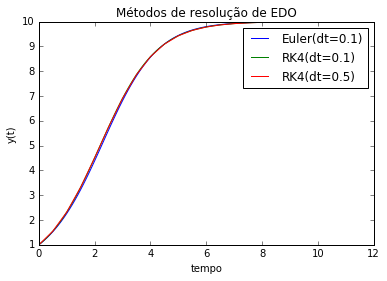

In [9]:
T1, Y1 = euler(f, y0=1, tf=10, tau=0.1)
T2, Y2 = rk4(f, y0=1, tf=10, tau=0.1)
T3, Y3 = rk4(f, y0=1, tf=10, tau=0.5)
plt.plot(T1, Y1, label='Euler(dt=0.1)')
plt.plot(T2, Y2, label='RK4(dt=0.1)')
plt.plot(T3, Y3, label='RK4(dt=0.5)')
plt.legend(loc='best')
plt.title('Métodos de resolução de EDO')
plt.xlabel('tempo')
plt.ylabel('y(t)')


Aparentemente todos métodos concordam entre si! Vamos analisar com mais cuidado agora. Para isso, iremos comparar a solução rk4 com um dt muito pequeno, tomando-a como a verdade (ou muito próxima disso), com o método de Euler e o próprio rk4 em diferentes configurações.

In [10]:
T_real, Y_real = rk4(f, y0=1, tf=10, tau=1e-4)

# Usamos a função interp do numpy para interpolar os resultados obtidos para qualquer t
def y_real(t):
    return np.interp(t, T_real, Y_real)

Agora vamos aos gráficos das diferenças entre os valores de Y obtidos e o valor correto.

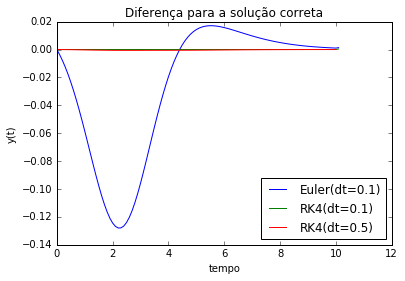

In [11]:
T1, Y1 = euler(f, y0=1, tf=10, tau=0.1)
T2, Y2 = rk4(f, y0=1, tf=10, tau=0.1)
T3, Y3 = rk4(f, y0=1, tf=10, tau=0.5)
plt.plot(T1, Y1 - y_real(T1), label='Euler(dt=0.1)')
plt.plot(T2, Y2 - y_real(T2), label='RK4(dt=0.1)')
plt.plot(T3, Y3 - y_real(T3), label='RK4(dt=0.5)')
plt.legend(loc='best')
plt.title('Diferença para a solução correta')
plt.xlabel('tempo')
plt.ylabel('y(t)')


O Euler foi tão pior que nem conseguimos distinguir a soluções RK4 da solução correta! Avaliamos a performance
de cada uma.

In [12]:
%timeit -n1000 euler(f, y0=1, tf=10, tau=0.1)
%timeit -n1000 rk4(f, y0=1, tf=10, tau=0.1)
%timeit -n1000 rk4(f, y0=1, tf=10, tau=0.5)

1000 loops, best of 3: 109 µs per loop
1000 loops, best of 3: 295 µs per loop
1000 loops, best of 3: 60.5 µs per loop


Vemos que o RK4 é cerca de 3 vezes mais lento que o Euler para o mesmo passo, mas produz resultados substancialmente melhores (em teoria este valor deveria ser mais próximo de 4, pois o RK4 utiliza quatro avaliações de f(y, t) para calcular k1, k2, k3 e k4). Mesmo o RK4 com um passo 5 vezes maior que o método de Euler produz resultados muito melhores e roda quase na metade do tempo. 

Na realidade, vemos que é necessário um passo da ordem de 10 vezes maior que o método de Euler para obter uma
inferência de qualidade equivalente. Neste caso, o RK4 se mostrou cerca de 5 vezes mais rápido que o método de Euler.

1000 loops, best of 3: 108 µs per loop
1000 loops, best of 3: 9.56 µs per loop


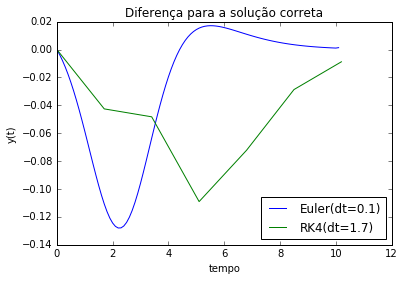

In [13]:
tau = 1.7
T1, Y1 = euler(f, y0=1, tf=10, tau=0.1)
T2, Y2 = rk4(f, y0=1, tf=10, tau=tau)

# Realiza gráficos
plt.plot(T1, Y1 - y_real(T1), label='Euler(dt=0.1)')
plt.plot(T2, Y2 - y_real(T2), label='RK4(dt=%.1f)' % tau)
plt.legend(loc='best')
plt.title('Diferença para a solução correta')
plt.xlabel('tempo')
plt.ylabel('y(t)')

# Mostra tempos
%timeit -n1000 euler(f, y0=1, tf=10, tau=0.1)
%timeit -n1000 euler(f, y0=1, tf=10, tau=tau)

## Sistemas de EDOs

Vários modelos matemáticos se baseiam em sistemas de equações diferenciais. Ou seja, ao invés de y(t) ser uma função escalar do tempo, ela assume um valor vetorial. Da mesma forma, f(y, t) recebe um vetor y e o tempo t e retorna um vetor de derivadas.

Vamos investigar um sistema famoso, proposto inicialmente por Edward Lorenz para simular variáveis climáticas. Não vamos nos ocupar muito sobre o significado das variáveis e sim sobre o seu comportamento já que Lorenz reconheceu o primeiro sistema caótico.

Vamos às equações. São três variáveis (x, y e z) dependentes do tempo. As equações diferenciais são:

    $x'(t) = \sigma (y - x)$,

    $y'(t) = x (\rho - z) - y$,

    $z'(t) = xy - \beta z$,

Onde os valores estudados por Lorenz (e que produzem comportamento caótico) são $\sigma=10$, $\rho=28$ e $\beta=8/3$.

Note que as derivadas de uma função dependem dos valores das outras. Desta forma, não é possível resolver as equações separadamente para x, y e z. Precisamos resolvê-las todas juntas. 

Felizmente, os métodos de resolução de equações diferenciais continuam os mesmos. Basta considerar que y0 é agora um vetor com as coordenadas iniciais de x, y e z e que f(y, t) recebe um vetor e retorna outro vetor 
com a derivada de cada coordenada.

In [14]:
# Definimos os valores das constantes
sigma = 10
rho = 28
beta = 8 / 3


# Não podemos utilizar listas pois elas não definem operações matemáticas.
# Convertemos tudo para arrays do numpy.
y0 = np.array([1, 1, 1])

def f(y_vec, t):
    x, y, z = y_vec
    return np.array([
        sigma * (y - x),
        x * (rho - z) - y,
        x * y - beta * z,
    ])

T, Y_vec = rk4(f, y0=y0, tf=30, tau=0.001)

In [15]:
# Y_vec é uma matriz em que cada linha é um vetor com as coordenadas [x, y, z]
Y_vec.shape, Y_vec[0]

((30001, 3), array([ 1.,  1.,  1.]))

In [16]:
# Queremos transformar em 3 vetores X, Y, Z com várias coordenadas
# Para isto, basta pegar as linhas da matriz transposta
X, Y, Z = Y_vec.T

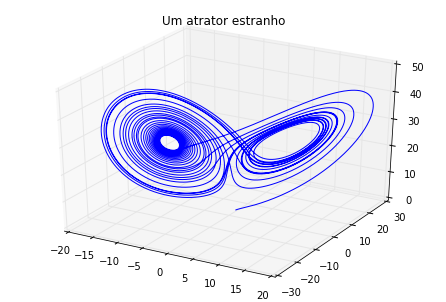

In [19]:
# Vamos fazer um gráfico 3d
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)
ax.plot(X, Y, Z)
plt.title('Um atrator estranho', axes=ax)

## Zumbis

Vamos usar equações diferenciais para modelar a dinâmica de Zumbis durante o apocalipse. Esta é uma área fértil do estudo de EDOs, com várias publicações [citar?] e geralmente é tratada como modelos específicos de dinâmica epidemológica.

Ao modelar uma ataque zumbi, temos que ter em mente algumas variáveis:

* h(t) é a população humana no tempo t
* z(t) é a população de zumbis
* c(t) são os corpos humanos que eventualmente podem virar zumbis

O segredo da modelagem é encontrar os termos de transformação de uma variável na outra. A maior parte dos termos
irá aparecer em duas equações, em uma com o sinal positivo e em outra com o sinal negativo. 

Começamos com um modelo simples que não envolve zumbis.

$$\begin{align}
  \frac{dh}{dt} &= \alpha h - \beta h\\
  \frac{dc}{dt} &= \beta h -\gamma c \\
\end{align}$$

Neste modelo, $\alpha$ representa a taxa de natalidade da população e determina o crescimento exponencial devido
aos nascimentos. O termo $-\beta h$ representa a taxa de mortalidade e implica na diminuição de h com o tempo. Note que ele aparece com o sinal positivo na equação para a dinâmica dos corpos. Isto significa que para cada humano que morre, um corpo é criado. Os próprios corpos possuem uma taxa de putrefação $\gamma c$ que implica num decaimento da quantidade de corpos com o tempo, até que um ponto que eles não seriam mais transformados em zumbis.

Vamos supor que o tempo t está medido em semanas e cada unidade de $h(t)$ e $c(t)$ representem 1 milhão de pessoas para estimar valores para $\alpha$, $\beta$, $\gamma$ e os valores iniciais de $h$ e $c$. Consideramos uma população da escala da brasileira para atribuir os valores iniciais $h_0 = 200$ e $c_0 = 0$. 

$\beta$ está associado à expectativa de vida média. Supondo que as pessoas vivem em média 70 anos (ou 3652 semanas), podemos supor 1/3652 da população deve morrer a cada semana. Assim adotamos este valor: $\beta = \frac{1}{3652}$.

A diferença $\alpha - \beta$ representa o crescimento demográfico total por semana. Rearrumando os termos, teríamos $\frac{dh}{h} = (\alpha - \beta) dt$. Sabemos que a cada ano (54 semanas) a população aumenta 1%. A cada semana teríamos algo em torno de 1/54 disto. Assim, estipulamos que $\alpha - \beta = 0.01/54$ ou $\alpha = \beta + 0.01/54$.

Finalmente, o termo $\gamma$ representa a taxa de putrefação e está associado ao tempo médio que demora para um corpo se deteriorar ao ponto de não poder ser mais transformável em zumbi. Estimamos este valor em cinco semanas, de forma que $\gamma = 1/5$

Passamos para código.

In [30]:
# Constantes
h0 = 200
c0 = 0
gamma = 1/5
beta = 1/3652
alpha = beta + 0.01/54

# Dinâmica populacional
def f(y, t):
    h, c = y
    return np.array([
        alpha * h - beta * h,
        beta * h - gamma * c,
    ])

Agora resolvemos utilizando o RK4. Investigamos o comportamento ao longo de aproximadamente 10 anos (ou 500 semanas). 

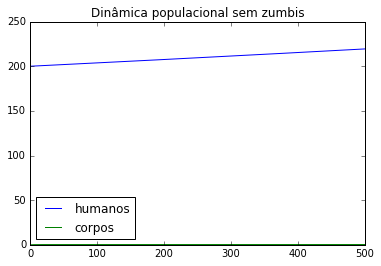

In [32]:
T, Y = rk4(f, y0=np.array([h0, c0]), tf=500, tau=0.5)
H, C = Y.T

plt.plot(T, H, label='humanos')
plt.plot(T, C, label='corpos')
plt.title('Dinâmica populacional sem zumbis')
plt.legend(loc='best')

Nada muito emocionante... A população cresce lentamente (ao longo de muitos séculos veremos um crescimento exponencial) e a quantidade de corpos fica parada em um valor fixo muito pequeno (da ordem de 0.3, se você quiser investigar). Mudamos o gráfico para tornar o último mais visível.

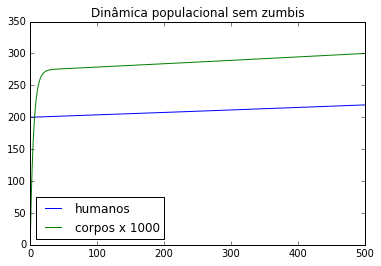

In [34]:
plt.plot(T, H, label='humanos')
plt.plot(T, C * 1000, label='corpos x 1000')
plt.title('Dinâmica populacional sem zumbis')
plt.legend(loc='best')

Agora queremos incluir zumbis no nosso modelo! Cada corpo disponível possui uma chance espontânea de virar 
zumbi (por causa de experimentos alienígenas, talvez). Isto cria um termo do tipo $-\eta c$ na equação para os
corpos e o termo correspondente com o sinal positivo na equação para os zumbis.

$$\begin{align}
  \frac{dh}{dt} &= \alpha h - \beta h\\
  \frac{dc}{dt} &= \beta h -\gamma c -\eta c \\
  \frac{dz}{dt} &= \eta c \\
\end{align}$$

Além disto, cada vez que um zumbi encontra um humano, pode haver uma conversão: o zumbi mata o humano e transforma-o em zumbi. Como o número de encontros é proporcional tanto à população humana quanto à população zumbi, isto induz um termo do tipo $\zeta h z$.

$$\begin{align}
  \frac{dh}{dt} &= \alpha h - \beta h - \zeta h z\\
  \frac{dc}{dt} &= \beta h -\gamma c -\eta c \\
  \frac{dz}{dt} &= \eta c + \zeta h z\\
\end{align}$$

Vamos ao código!

In [58]:
# Condições iniciais
h0 = 200
c0 = 0
z0 = 1e-6  # Dr. Zombeinstein criou um zumbi!

# Constantes
gamma = 1/5
beta = 1/3652
alpha = beta + 0.01/54
eta = gamma / 1e6  # 1 corpo um milhão vira zumbi espontaneamente
zeta = 1e-3        # valor empírico :P

# Dinâmica populacional
def f(y, t):
    h, c, z = y
    return np.array([
        alpha * h - beta * h - zeta * h * z,
        beta * h - gamma * c - eta * c,
        eta * c + zeta * h * z,
    ])

Fazemos um gráfico...

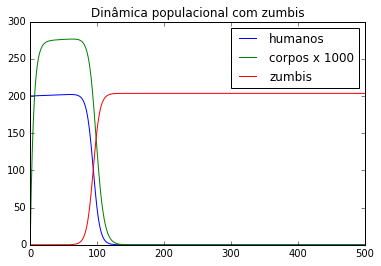

In [59]:
T, Y = rk4(f, y0=np.array([h0, c0, z0]), tf=500, tau=0.5)
H, C, Z = Y.T

plt.plot(T, H, label='humanos')
plt.plot(T, C * 1000, label='corpos x 1000')
plt.plot(T, Z, label='zumbis')
plt.title('Dinâmica populacional com zumbis')
plt.legend(loc='best')

Pobres humanos...

### Fator Walking Dead

Nosso modelo não dá a menor chance para os humanos. O comportamento acima poderia ser antecipado já que não existe nenhum fator que permita diminuir a população de zumbis. Assim o comportamento inevitável é que a população zumbi cresce até liquidar o último humano vivo.

Sabemos por diversas referências (TV, quadrinhos, filmes...) que não funciona bem assim. Existe uma população de
humanos corajosos que consegue matar os zumbis. Para modelar isto, dividimos $h$ em duas partes: $h_1$ são os humanos normais e $h_2$ são os caçadores de zumbis. Montamos algumas equações:

$$\begin{align}
  \frac{dh_1}{dt} &= \alpha (h_1 + h_2) - \beta_1 h_1 - \zeta_1 h_1 z\\
  \frac{dh_2}{dt} &= -\beta_2 h_2 \\
  \frac{dc}{dt} &= \beta_1 h_1 + \beta_2 h_2 -\gamma c -\eta c \\
  \frac{dz}{dt} &= \eta c + \zeta_1 h_1 z - \zeta_2 h_2 z\\
\end{align}$$

Aqui assumimos que a população reproduz com um fator proporcional ao total da população humana, mas que as taxas de mortalidade naturais podem ser diferentes (heróis morrem mais cedo). Assim assumimos que $\beta_2 = 2 \beta_1$. Vamos assumir que $\zeta_2 = \zeta_1$ para dizer que é igualmente provável que um destes heróis mate um zumbi que um zumbi mate um humano normal.

Vamos à simulação...

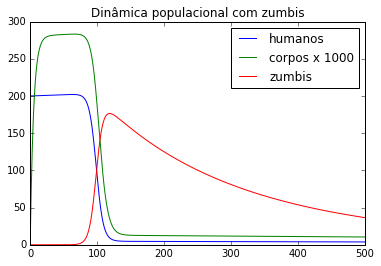

In [63]:
# Condições iniciais
h1_0 = 195
h2_0 = 5   # 5.000.000 destes bravos heróis
c0 = 0
z0 = 1e-6

# Constantes
gamma = 1/5
beta1 = 1/3652
beta2 = 2 * beta1
alpha = beta + 0.01/54
eta = gamma / 1e6
zeta1 = 1e-3     
zeta2 = 1e-3     

# Dinâmica populacional
def f(y, t):
    h1, h2, c, z = y
    return np.array([
        alpha * (h1 + h2) - beta1 * h1 - zeta1 * h1 * z,
        - beta2 * h2,
        beta1 * h1 + beta2 * h2 - gamma * c - eta * c,
        eta * c + zeta1 * h1 * z - zeta2 * h2 * z,
    ])

# Gráficos
T, Y = rk4(f, y0=np.array([h1_0, h2_0, c0, z0]), tf=500, tau=0.5)
H1, H2, C, Z = Y.T

plt.plot(T, H1 + H2, label='humanos')
plt.plot(T, C * 1000, label='corpos x 1000')
plt.plot(T, Z, label='zumbis')
plt.title('Dinâmica populacional com zumbis')
plt.legend(loc='best')

Agora para um tempo mais longo

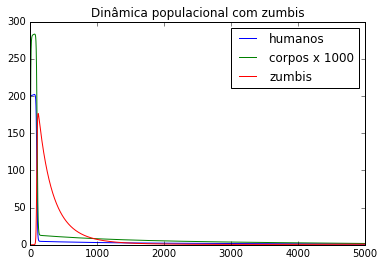

In [64]:
T, Y = rk4(f, y0=np.array([h1_0, h2_0, c0, z0]), tf=5000, tau=0.5)
H1, H2, C, Z = Y.T

plt.plot(T, H1 + H2, label='humanos')
plt.plot(T, C * 1000, label='corpos x 1000')
plt.plot(T, Z, label='zumbis')
plt.title('Dinâmica populacional com zumbis')
plt.legend(loc='best')

Novamente um triste fim para os humanos: depois da primeira onda de ataques, praticamente toda população humana é dizimada, sobrando apenas os heróis em $h_2$. Gradualmente a idade ataca nossos heróis e a população é reduzida a zero ao longo dos anos...

Claramente é necessário um mecanismo de transformar um humano normal de $h_1$ em um combativo caçador de zumbis de $h_2$. Para isto é necessário ensinar nossos humanos a evitar situações perigosas, a usar armas, saber se esconder, saber garimpar recursos, etc. Com isto, entra uma nova variável: a educação $e(t)$. Ela mede a taxa com que podemos ensinar um humano normal a virar um caçador de zumbis.

$$\begin{align}
  \frac{dh_1}{dt} &= \alpha (h_1 + h_2) - \beta_1 h_1 - \zeta_1 h_1 z - e h_1 \\
  \frac{dh_2}{dt} &= -\beta_2 h_2 + e h_1 \\
  \frac{dc}{dt} &= \beta_1 h_1 + \beta_2 h_2 -\gamma c -\eta c \\
  \frac{dz}{dt} &= \eta c + \zeta_1 h_1 z - \zeta_2 h_2 z\\
\end{align}$$

Assumindo um valor de e constante, temos a seguinte dinâmica:

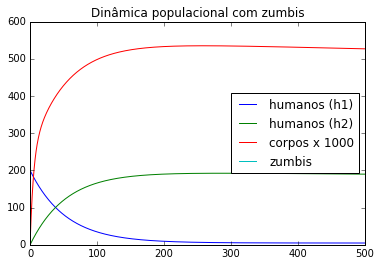

In [73]:
# Condições iniciais
h1_0 = 200
h2_0 = 0
c0 = 0
z0 = 1e-6
e = 1/54

# Constantes
gamma = 1/5
beta1 = 1/3652
beta2 = 2 * beta1
alpha = beta + 0.01/54
eta = gamma / 1e6
zeta1 = 1e-3     
zeta2 = 1e-3     

# Dinâmica populacional
def f(y, t):
    h1, h2, c, z = y
    return np.array([
        alpha * (h1 + h2) - beta1 * h1 - zeta1 * h1 * z - e * h1,
        - beta2 * h2 + e * h1,
        beta1 * h1 + beta2 * h2 - gamma * c - eta * c,
        eta * c + zeta1 * h1 * z - zeta2 * h2 * z,
    ])

# Gráficos
T, Y = rk4(f, y0=np.array([h1_0, h2_0, c0, z0]), tf=500, tau=0.5)
H1, H2, C, Z = Y.T

plt.plot(T, H1, label='humanos (h1)')
plt.plot(T, H2, label='humanos (h2)')
plt.plot(T, C * 1000, label='corpos x 1000')
plt.plot(T, Z, label='zumbis')
plt.title('Dinâmica populacional com zumbis')
plt.legend(loc='best')

Todos os humanos viram caçadores de zumbis e todos os zumbis morrem. Nada muito interessante aqui...

O problema, é que devemos modelar e(t) como uma variável dinâmica. Os humanos só se sentiram compelidos a treinar para virarem caçadores de zumbis se existirem muitos zumbis. Caso contrário, devem seguir profissões normais como engenheiros, contadores, vendedores, artistas de circo, etc. 

Deste modo, $e(t)$ deve começar em zero (antes de aparecer o primeiro zumbi) e deve crescer com o número de encontros de humanos $h_1$ que foram convertidos em zumbis ($\rho h_1 z$). Mas tudo isso deve estar limitado a um fator $e_{max}$ que denota a taxa de conversão máxima (multiplique por $\max(0, e_{max} - e)$).

Além disto, devemos acrescentar um fator de esquecimento, que fazem as pessoas pararem de se preocupar com zumbis (e a ensinar os métodos de um verdadeiro caçador de zumbi) se por um acaso os zumbis forem exterminados (algo como $-\kappa e$, para criar um decaimento exponencial).

$$\frac{de}{dt} = \rho h_1 z \max(0, e_{max} - e) - \kappa e $$

Acrescentando este fator nas nossas equações, o resultado fica:

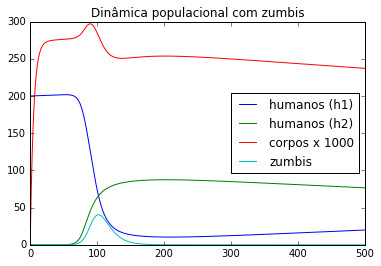

In [87]:
# Condições iniciais
h1_0 = 200
h2_0 = 0
c0 = 0
z0 = 1e-6
e0 = 0

# Constantes
gamma = 1/5
beta1 = 1/3652
beta2 = 2 * beta1
alpha = beta + 0.01/54
eta = gamma / 1e6
zeta1 = 1e-3     
zeta2 = 1e-3
rho = 2e-4
kappa = 2e-2
e_max = 1/54

# Dinâmica populacional
def f(y, t):
    h1, h2, c, z, e = y
    return np.array([
        alpha * (h1 + h2) - beta1 * h1 - zeta1 * h1 * z - e * h1,
        - beta2 * h2 + e * h1,
        beta1 * h1 + beta2 * h2 - gamma * c - eta * c,
        eta * c + zeta1 * h1 * z - zeta2 * h2 * z,
        rho * z * h1 * max(0, e_max - e) - kappa * e,
    ])

# Gráficos
T, Y = rk4(f, y0=np.array([h1_0, h2_0, c0, z0, e0]), tf=500, tau=0.5)
H1, H2, C, Z, E = Y.T

plt.plot(T, H1, label='humanos (h1)')
plt.plot(T, H2, label='humanos (h2)')
plt.plot(T, C * 1000, label='corpos x 1000')
plt.plot(T, Z, label='zumbis')
plt.title('Dinâmica populacional com zumbis')
plt.legend(loc='best')

Esta dinâmica possui um efeito interessante de "ondas de ataque zumbi" em longo prazo

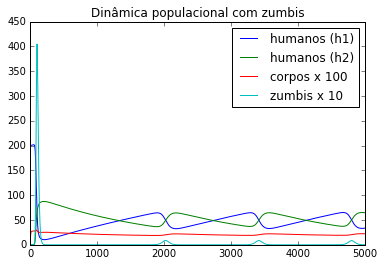

In [92]:
# Gráficos
T, Y = rk4(f, y0=np.array([h1_0, h2_0, c0, z0, e0]), tf=5000, tau=0.5)
H1, H2, C, Z, E = Y.T

plt.plot(T, H1, label='humanos (h1)')
plt.plot(T, H2, label='humanos (h2)')
plt.plot(T, C * 100, label='corpos x 100')
plt.plot(T, Z * 10, label='zumbis x 10')
plt.title('Dinâmica populacional com zumbis')
plt.legend(loc='best')

Concluímos nosso passeio sobre o estado da arte em dinâmica populacional zumbi.